# Libraries

In [ ]:
import pandas as pd
import numpy as np


import re 

## Spacy ##
import spacy
import spacy_lookups_data
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

## sklearn ##
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer


import umap


# ML Models

In [2]:
data = pd.read_csv('data/fake_job_postings.csv')

# Categorical

In [3]:
categorical_columns = data[["job_id","employment_type", "required_experience", 
                            "required_education", "industry", "function"]].copy()

In [4]:
categorical_columns = categorical_columns.fillna("other")


In [5]:
for column in categorical_columns.columns[1:]:
    categorical_columns[column] = categorical_columns[column].str.lower()

In [6]:
unique_industries_percentage = categorical_columns['industry'].value_counts()/categorical_columns.shape[0]*100

unique_industries_indexes = list(unique_industries_percentage[unique_industries_percentage >= 1].index)

other_industry = categorical_columns["industry"][~categorical_columns["industry"].isin(unique_industries_indexes)].unique()

categorical_columns["industry"].replace(other_industry,"other", inplace=True)

In [7]:
vals_to_replace = {"not applicable":"other", "mid-senior level":"associate", "director":"executive"}
categorical_columns["required_experience"] = categorical_columns["required_experience"].replace(vals_to_replace)


vals_to_replace = {"information technology and services":"information technologies","internet":"information technologies",
                   "computer software":"information technologies", "telecommunications":"information technologies"}

categorical_columns["industry"] = categorical_columns["industry"].replace(vals_to_replace)


vals_to_replace = {"unspecified":"other","some high school coursework":"high school or equivalent",
                   "vocational - hs diploma":"high school or equivalent", "mid-senior level":"associate",
                   "some college coursework completed":"associate degree", "professional":"vocational",
                   "vocational - degree":"vocational","certification":"vocational"}

categorical_columns["required_education"] = categorical_columns["required_education"].replace(vals_to_replace)


vals_to_replace = {"design":"marketing", "public relations":"marketing", "advertising":"marketing", "art/creative":"marketing", 
                   "financial analyst":"finance", "accounting/auditing":"finance","financial analyst":"finance",
                   "training":"human resources","data analyst":"information technology","supply chain":"production",
                   "manufacturing":"production", "quality assurance":"production","project management":"management",
                   "product management":"management", "strategy/planning": "management","sales":"business development",
                   "general business":"business development", "business analyst":"business development",
                   "purchasing":"business development","research":"research and development",
                   "science":"research and development"}

categorical_columns["function"] = categorical_columns["function"].replace(vals_to_replace)


In [8]:
# Split of localitation column

# new data frame with split value columns 
new = data["location"].str.split(",", n = 2, expand = True) 
  
# making separate columns from new data frame 
data["Country"]= new[0] 
data["Region"]= new[1]
data["City"] = new[2]


data['Country'].value_counts() # La distribución del 3r contry es menor a mil, y luego baja en picado.
top_countries = data['Country'].value_counts().head(4).index
other_countries = data['Country'][~data['Country'].isin(top_countries)].unique()

data['Country'].replace(other_countries, 'OTHER', inplace=True)

categorical_columns.loc[:,'Country'] = data.loc[:,'Country']

In [9]:
categorical_columns_dummies = pd.get_dummies(categorical_columns, columns = categorical_columns.columns[1:])

In [10]:
categorical_columns_dummies.head()

,job_id,employment_type_contract,employment_type_full-time,employment_type_other,employment_type_part-time,employment_type_temporary,required_experience_associate,required_experience_entry level,required_experience_executive,required_experience_internship,...,function_marketing,function_other,function_production,function_research and development,function_writing/editing,Country_CA,Country_GB,Country_GR,Country_OTHER,Country_US
0,1,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Numerical

In [11]:
numerical_columns = data[['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].copy()

In [12]:
salary_rows_in_benefits = data['benefits'].str.extractall(r'(\$\d+\,?\d+)').reset_index()['level_0'].unique()
salary_rows_in_description = data['description'].str.extractall(r'(\$\d+\,?\d+)').reset_index()['level_0'].unique()


data.loc[salary_rows_in_benefits, 'salary_range'] = 1
data.loc[salary_rows_in_description, 'salary_range'] = 1

nan_salaries = data['salary_range'].isnull()
with_salaries = list(data['salary_range'][~data['salary_range'].isnull()].unique())

data['salary_range'] = data['salary_range'].replace(with_salaries, 1)
data['salary_range'] = data['salary_range'].fillna(0)

numerical_columns['salary_range'] = data['salary_range']

In [13]:
numerical_columns.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,salary_range
0,1,0,1,0,0,0.0
1,2,0,1,0,0,1.0
2,3,0,1,0,0,0.0
3,4,0,1,0,0,0.0
4,5,0,1,1,0,0.0


# Text


In [14]:
data_text = data[['job_id', 'title','department', 'company_profile', 'description', 'requirements', 'benefits']].copy()

In [15]:
data_text = data_text.fillna('')
text_columns = data_text[['job_id']]
text_columns['text'] = data_text.iloc[:,1:].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

C:\Users\jcmor\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
text_columns.head()

,job_id,text
0,1,"Marketing InternMarketingWe're Food52, and we'..."
1,2,Customer Service - Cloud Video ProductionSucce...
2,3,Commissioning Machinery Assistant (CMA)Valor S...
3,4,Account Executive - Washington DCSalesOur pass...
4,5,Bill Review ManagerSpotSource Solutions LLC is...


In [17]:
def clean_urls(column):
    '''
    This functions takes an string and returns an string 
    with the url removed and the words in lower case.
    '''
    return column.apply(lambda x: x.lower()).apply(lambda x: re.sub('http[s]?://\S+', '', x))



text_columns['text'] = clean_urls(text_columns['text'])

C:\Users\jcmor\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [18]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser']) 
nlp.max_length = 15000000

def string_to_lemma(string):
    '''
    This function takes a sentence and returns the list of all lemma
    '''
    doc = nlp(string)
    l_token = [token.lemma_ for token in doc if not token.is_punct 
               | token.is_space | token.is_stop | token.is_digit & token.is_oov] 
    #singular_token = [token for token in nlp(l_token) if token.tag_ == 'NNPS' | token.tag_ == 'NNS']
    return ' '.join(l_token)


text_columns['text'] = text_columns['text'].apply(lambda row: string_to_lemma(row))

C:\Users\jcmor\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [19]:
text_columns.head()

,job_id,text
0,1,marketing internmarketingwe're food52 create g...
1,2,customer service cloud video productionsuccess...
2,3,commission machinery assistant cma)valor servi...
3,4,account executive washington dcsalesour passio...
4,5,bill review managerspotsource solution llc glo...


In [20]:
text_columns['text'].isnull().sum()

0

In [21]:
tfidf = TfidfVectorizer().fit_transform(text_columns['text'])


In [22]:
tfidf

<17880x112575 sparse matrix of type '<class 'numpy.float64'>'
	with 2919660 stored elements in Compressed Sparse Row format>

In [23]:
mapper = umap.UMAP(metric='hellinger', random_state=42).fit(tfidf)

In [25]:
embedding = mapper.transform(tfidf)

In [34]:
embedding.shape
"""Nos lo divide en dos, podriamos poner alguna mas"""

(17880, 2)

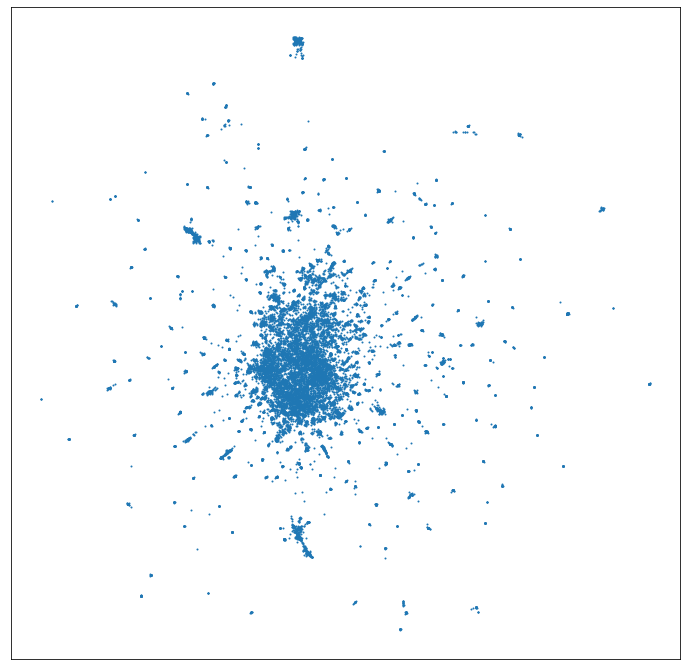

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(embedding[:, 0], embedding[:, 1], s=1, c=news_test.target, cmap='Spectral')
ax.set(xticks=[], yticks=[]);

In [41]:
umap_df = pd.DataFrame(embedding)

In [44]:
text_colums_umap = pd.concat([text_columns['job_id'], umap_df], axis =1)

In [46]:
text_colums_umap.head()

,job_id,0,1
0,1,-5.284934,-2.366045
1,2,3.447525,0.811648
2,3,0.357541,4.447133
3,4,9.698580,-3.118088
4,5,6.679002,-4.354322


# Merge

In [55]:
result = pd.concat([categorical_columns_dummies, numerical_columns, text_colums_umap], axis=1,levels=None ,sort=False)

In [56]:
result.head()

,job_id,employment_type_contract,employment_type_full-time,employment_type_other,employment_type_part-time,employment_type_temporary,required_experience_associate,required_experience_entry level,required_experience_executive,required_experience_internship,...,Country_US,job_id,telecommuting,has_company_logo,has_questions,fraudulent,salary_range,job_id,0,1
0,1,0,0,1,0,0,0,0,0,1,...,1,1,0,1,0,0,0.0,1,-5.284934,-2.366045
1,2,0,1,0,0,0,0,0,0,0,...,0,2,0,1,0,0,1.0,2,3.447525,0.811648
2,3,0,0,1,0,0,0,0,0,0,...,1,3,0,1,0,0,0.0,3,0.357541,4.447133
3,4,0,1,0,0,0,1,0,0,0,...,1,4,0,1,0,0,0.0,4,9.698580,-3.118088
4,5,0,1,0,0,0,1,0,0,0,...,1,5,0,1,1,0,0.0,5,6.679002,-4.354322


In [57]:
result.drop('job_id',axis =1 ,inplace =True)

In [58]:
result.head()

,employment_type_contract,employment_type_full-time,employment_type_other,employment_type_part-time,employment_type_temporary,required_experience_associate,required_experience_entry level,required_experience_executive,required_experience_internship,required_experience_other,...,Country_GR,Country_OTHER,Country_US,telecommuting,has_company_logo,has_questions,fraudulent,salary_range,0,1
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0.0,-5.284934,-2.366045
1,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,1.0,3.447525,0.811648
2,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0.0,0.357541,4.447133
3,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0.0,9.698580,-3.118088
4,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0.0,6.679002,-4.354322
